# Primary care facilities (hospitals, clinics, off-site public access devices, etc.)


### Becareful some times the code doesn't run and gurobi doesn't find a solution  because the model is unfeasible (because of the randomization of the nodes). In this case just run again all the notebook again

With this model, we look for the position of hospitals and clinics to minimize the distance between the patient, hospitals and clinics. 
This can help us, for example, to decise where to build an hospital in the future.

## Definition of the problem
### Sets
$\text {I : The set of demand points i}$\
$\text {K : The set of candidate locations for a level-1 PCF (e.g., clinics) k}$\
$\text {J : The set of candidate locations for a level-2 PCF (e.g., hospitals) j}$
### Parameters
$d_{ik} \text {: The travel distance (or time) between demand point i ∈ I and a level-1 PCF in candidate location k ∈ K}$\
$d_{ik} \text {: The travel distance (or time) between a level-1 PCF in candidate location k ∈ K and a level-2 PCF in candidate location j ∈ J}$\
$w_i \text {: The population size at demand point i ∈ I }$\
$C_{k}^1 \text {: The capacity of the clinic k}$\
$C_{j}^2 \text {: The capacity of the hospital j}$\
$p \text {: The number of clinics to be established}$\
$q \text {: The number of hospitals to be established}$\
$\theta_k \text {: The proportion of patients in the clinic k who have to go to an hospital}$\

### Variables
$
x_{k}^1=
\begin{cases}
1 \text{ if clinic } k \text{ is activated},\\
0 \text{ otherwise}
\end{cases}
$\
$
x_{j}^2=
\begin{cases}
1 \text{ if hospital } j \text{ is activated},\\
0 \text{ otherwise}
\end{cases}
$\
$u_{ik} \text {: The flow of patients between demand point i and the clinic k (e.g. flow of arc going from node i to node k)}$\
$v_{kj} \text {: The flow of patients from the clinic k who have to ho to the hospital j (e.g. flow of arc going from node k to node j)}$

### Objective function
$$
\min  \sum_{i \in I}^n \sum_{k \in K} d_{ik}* u_{ik} + \sum_{k \in K}^n \sum_{j \in J} d_{kj}* v_{kj}
$$

### Constraints
* Flow balance 
$$
\sum_{k \in K} u_{ik} = w_i, \forall i \in I
$$
$$
 \sum_{j \in J} v_{kj} = \theta_k  \sum_{i \in I} u_{ik}, \forall k \in K
$$
* Capacity
$$
\sum_{i \in I} u_{ik} \leq C_k^1 * x_k^1, \forall k \in K
$$\
$$
\sum_{k \in K} v_{kj} \leq C_j^2 * x_j^2, \forall j \in J
$$
* Number of clinics and hospitals established 
$$
\sum_{k \in K} x_k^1 = p
$$\
$$
\sum_{j \in J} x_j^2 = q
$$\
* Domain constraints
$$
\forall i \in I, \forall k \in K, u_{ik} \geq 0
$$ \
$$
\forall k \in K, \forall j \in J, v_{kj} \geq 0 
$$\
$$
\forall k \in K, x_k^1 \in \{0,1\}
$$\
$$
\forall j \in J, x_j^2 \in \{0,1\}
$$

In [367]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gb

%matplotlib inline

In [368]:
#Drawing function

def DrawInitG(G, figure_size, withedges=False):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]
    
    
    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6,\
                           node_shape='o', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    if withedges:
        nx.draw_networkx_edges(G,pos=pos, alpha=1.0)
        labels = {(i,j):G.get_edge_data(i,j,'dist').get('dist') for i,j in G.edges()}
        nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=labels)
    
    plt.axis('off')
    plt.show()
    
def DrawSol(G, figure_size, x):
    
    plt.figure(figsize=figure_size)
    
    pos = {i:(G.nodes[i]['x'], G.nodes[i]['y']) for i in G.nodes()}
    color_list =  [(G.nodes[i]['color']) for i in G.nodes()]
    location_type = [(G.nodes[i]['location_type']) for i in G.nodes()]

    nx.draw_networkx_nodes(G, pos=pos, linewidths=0.6, \
                           node_shape='o', node_size=500,\
                           node_color=color_list, edgecolors='black')
    
    nx.draw_networkx_labels(G, pos=pos, font_color='k')
    
    
    nx.draw_networkx_edges(G,pos=pos, edgelist = x, alpha=1.0)
    
        
    
    plt.axis('off')
    plt.show()

In [369]:
graph_size = 20

In [370]:
# Setting the network values (1)

number_of_clinic = 15
number_of_hospitals = 15
number_of_demand_points = 100

K = range(0, number_of_clinic)
J = range(number_of_clinic, number_of_clinic + number_of_hospitals)
I = range(number_of_clinic + number_of_hospitals, number_of_clinic + number_of_hospitals + number_of_demand_points)

index_of_clinic = list(K)
index_of_hospitals = list(J)
index_of_demand_points = list(I)

area_size = 20
# for Nantes area_size = 20
# p = 5
# q = 5
# nombre_habitant = 300 000
# Number of candidate clinic's to be established
p = 5
# Number of candidate hospital's to be established
q = 5

# Portion of patient in a clinic k referred to an hospital 
theta = {k:round(random.random(),2) for k in K}

In [371]:
theta

{0: 0.25,
 1: 0.57,
 2: 0.41,
 3: 0.91,
 4: 0.31,
 5: 0.13,
 6: 0.25,
 7: 0.66,
 8: 0.71,
 9: 0.6,
 10: 0.21,
 11: 0.57,
 12: 0.23,
 13: 0.61,
 14: 0.49}

In [372]:
print(index_of_clinic)
print(index_of_hospitals)
print(index_of_demand_points)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]


In [373]:
#Creating a random network and removing all edges

G = nx.complete_graph(number_of_clinic + number_of_hospitals + number_of_demand_points)
G = nx.create_empty_copy(G)
pos = nx.random_layout(G)

In [374]:
pos

{0: array([0.97428024, 0.8219143 ], dtype=float32),
 1: array([0.29587623, 0.9599731 ], dtype=float32),
 2: array([0.1784289 , 0.29182875], dtype=float32),
 3: array([0.12948878, 0.53540623], dtype=float32),
 4: array([0.39583102, 0.7513127 ], dtype=float32),
 5: array([0.27368537, 0.12255375], dtype=float32),
 6: array([0.59989226, 0.46996915], dtype=float32),
 7: array([0.82853717, 0.14478876], dtype=float32),
 8: array([0.65462786, 0.3361863 ], dtype=float32),
 9: array([0.81764567, 0.174996  ], dtype=float32),
 10: array([0.7885722, 0.566833 ], dtype=float32),
 11: array([0.3066099, 0.9915675], dtype=float32),
 12: array([0.05015234, 0.2944069 ], dtype=float32),
 13: array([0.73643535, 0.814004  ], dtype=float32),
 14: array([0.429898 , 0.9089173], dtype=float32),
 15: array([0.15766399, 0.8135181 ], dtype=float32),
 16: array([0.5731798 , 0.52673644], dtype=float32),
 17: array([0.8754086, 0.3546525], dtype=float32),
 18: array([0.9086709 , 0.16058569], dtype=float32),
 19: array(

In [375]:
#Setting the network values (2)
C = {}
for i in range(len(G)):
    if i >= 0 and i < number_of_clinic:
        C[i] = random.randrange(100,400,100)
        # a clinic can accommodate between 100 and 400 people
        # but we can also decide to give the same capacity for all clinics
    elif i >= number_of_clinic and i < number_of_clinic + number_of_hospitals:
        C[i] = random.randrange(500,2500,500)
        # an hospital can accommodate between 500 and 2500 people
        # but we can also decide to give the same capacity for all hospital
    else:
        C[i] = random.randrange(5,25)
        # population in node i

In [376]:
# Changing the size of the network

for i in range(len(pos.values())) :
    pos[i] = pos[i]*area_size

In [377]:
# Assinging the pos values to the x and y attribute of each node

for i in range(len(G)):
    if i in index_of_clinic[len(index_of_clinic) - 5 :]:
        # 5 (over 15) clinics are centered (the five last ones)
        G.nodes[i]["x"] = random.uniform(8, 12)
        G.nodes[i]["y"] = random.uniform(8, 12)
    elif i in index_of_hospitals[len(index_of_hospitals) - 5:]:
        # 5 (over 15) hospitals are centered (the five last ones)
        G.nodes[i]["x"] = random.uniform(8, 12)
        G.nodes[i]["y"] = random.uniform(8, 12)
    else:
        # for the rest of nodes the position is randomize
        # btw it can create problem after when we try to optimize, in this case run again the notebook to have new position
        G.nodes[i]["x"] = pos[i][0]
        G.nodes[i]["y"] = pos[i][1]

In [378]:
G.nodes(data=True)

NodeDataView({0: {'x': 19.485605, 'y': 16.438286}, 1: {'x': 5.917525, 'y': 19.199463}, 2: {'x': 3.568578, 'y': 5.836575}, 3: {'x': 2.5897756, 'y': 10.708124}, 4: {'x': 7.9166203, 'y': 15.026254}, 5: {'x': 5.473707, 'y': 2.451075}, 6: {'x': 11.997845, 'y': 9.399384}, 7: {'x': 16.570744, 'y': 2.895775}, 8: {'x': 13.092557, 'y': 6.723726}, 9: {'x': 16.352913, 'y': 3.4999201}, 10: {'x': 9.756341339467204, 'y': 8.628325608314974}, 11: {'x': 11.767183764354138, 'y': 9.824746287205917}, 12: {'x': 9.148347468951913, 'y': 10.963428988918409}, 13: {'x': 8.88374997422796, 'y': 9.844376474818366}, 14: {'x': 11.065235120711275, 'y': 11.965787920589516}, 15: {'x': 3.1532798, 'y': 16.270363}, 16: {'x': 11.463595, 'y': 10.534729}, 17: {'x': 17.508171, 'y': 7.09305}, 18: {'x': 18.173418, 'y': 3.2117138}, 19: {'x': 2.0132556, 'y': 19.163626}, 20: {'x': 16.43357, 'y': 2.3861136}, 21: {'x': 11.133907, 'y': 18.27611}, 22: {'x': 11.590351, 'y': 9.747507}, 23: {'x': 11.482688, 'y': 13.878603}, 24: {'x': 1.11

In [379]:
# Assining what type of location a node is and its color
# For each node, we give the capacity (of the clinic, the hospital or of the population in the demand point)

for i in range(len(G)):
    if i in index_of_clinic:
        G.nodes[i]['color'] = "blue"
        G.nodes[i]['location_type'] = "clinic"

        # if we want to be more realistic, uncomment the following lines

        # if i in index_of_clinic[len(index_of_clinic) - 5 :]:
        #     # the 5 clinics in the center have in general a bigger capacity than the others
        #     G.nodes[i]['capacity'] = 3000
        # else:
        #     # for the rest the capacity is random
        #     G.nodes[i]['capacity'] = C[i]

        # and comment the next line
        G.nodes[i]['capacity'] = C[i]

    elif i in index_of_hospitals:
        G.nodes[i]['color'] = "red"
        G.nodes[i]['location_type'] = "hospital"

        # if we want to be more realistic, uncomment the following lines

        # if i in index_of_hospitals[len(index_of_hospitals) - 5:]:
        #     # the 5 hospitals in the center have in general a bigger capacity than the others
        #     G.nodes[i]['capacity'] = 1500
        # else:
        #     # for the rest the capacity is random
        #     G.nodes[i]['capacity'] = C[i]

        # and comment the next line
        G.nodes[i]['capacity'] = C[i]
        
    else:
        G.nodes[i]['color'] = "green"
        G.nodes[i]['location_type'] = "demand point"
        G.nodes[i]['capacity'] = C[i]

In [380]:
G.nodes(data=True)

NodeDataView({0: {'x': 19.485605, 'y': 16.438286, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 1: {'x': 5.917525, 'y': 19.199463, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 2: {'x': 3.568578, 'y': 5.836575, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 3: {'x': 2.5897756, 'y': 10.708124, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 4: {'x': 7.9166203, 'y': 15.026254, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 5: {'x': 5.473707, 'y': 2.451075, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 6: {'x': 11.997845, 'y': 9.399384, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 7: {'x': 16.570744, 'y': 2.895775, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 8: {'x': 13.092557, 'y': 6.723726, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 9: {'x': 16.352913, 'y': 3.4999201, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 10: {'x': 9.75

In [381]:
# Creating the edges that are only useful, e.g the ones between demand point and clinic and clinic and hospital location
# Adding the cost (e.g distance) and naming it a for the distance between demand point and clinic or t between clinic and hospital

for source in index_of_demand_points:
    for target in index_of_clinic:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,a=distance, dist=distance)
        
for source in index_of_clinic:
    for target in index_of_hospitals:
        distance = np.sqrt((G.nodes[source]["x"]-G.nodes[target]["x"])**2 + (G.nodes[source]["y"]-G.nodes[target]["y"])**2)
        G.add_edge(source,target,t=distance, dist=distance)

In [382]:
G.edges(data=True)

EdgeDataView([(0, 30, {'a': 6.5542734988003675, 'dist': 6.5542734988003675}), (0, 31, {'a': 22.25955743514618, 'dist': 22.25955743514618}), (0, 32, {'a': 12.26065467263033, 'dist': 12.26065467263033}), (0, 33, {'a': 17.796694018002476, 'dist': 17.796694018002476}), (0, 34, {'a': 2.7268967058236835, 'dist': 2.7268967058236835}), (0, 35, {'a': 22.077714581506367, 'dist': 22.077714581506367}), (0, 36, {'a': 18.374738232320237, 'dist': 18.374738232320237}), (0, 37, {'a': 17.2268650571927, 'dist': 17.2268650571927}), (0, 38, {'a': 14.122438632287823, 'dist': 14.122438632287823}), (0, 39, {'a': 16.61921936112672, 'dist': 16.61921936112672}), (0, 40, {'a': 13.347948536626408, 'dist': 13.347948536626408}), (0, 41, {'a': 2.299005121335839, 'dist': 2.299005121335839}), (0, 42, {'a': 16.229261491443406, 'dist': 16.229261491443406}), (0, 43, {'a': 6.827753770719983, 'dist': 6.827753770719983}), (0, 44, {'a': 10.351128007119668, 'dist': 10.351128007119668}), (0, 45, {'a': 7.997211848663815, 'dist':

In [383]:
G.nodes(data=True)

NodeDataView({0: {'x': 19.485605, 'y': 16.438286, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 1: {'x': 5.917525, 'y': 19.199463, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 2: {'x': 3.568578, 'y': 5.836575, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 3: {'x': 2.5897756, 'y': 10.708124, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 4: {'x': 7.9166203, 'y': 15.026254, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 5: {'x': 5.473707, 'y': 2.451075, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 6: {'x': 11.997845, 'y': 9.399384, 'color': 'blue', 'location_type': 'clinic', 'capacity': 300}, 7: {'x': 16.570744, 'y': 2.895775, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 8: {'x': 13.092557, 'y': 6.723726, 'color': 'blue', 'location_type': 'clinic', 'capacity': 100}, 9: {'x': 16.352913, 'y': 3.4999201, 'color': 'blue', 'location_type': 'clinic', 'capacity': 200}, 10: {'x': 9.75

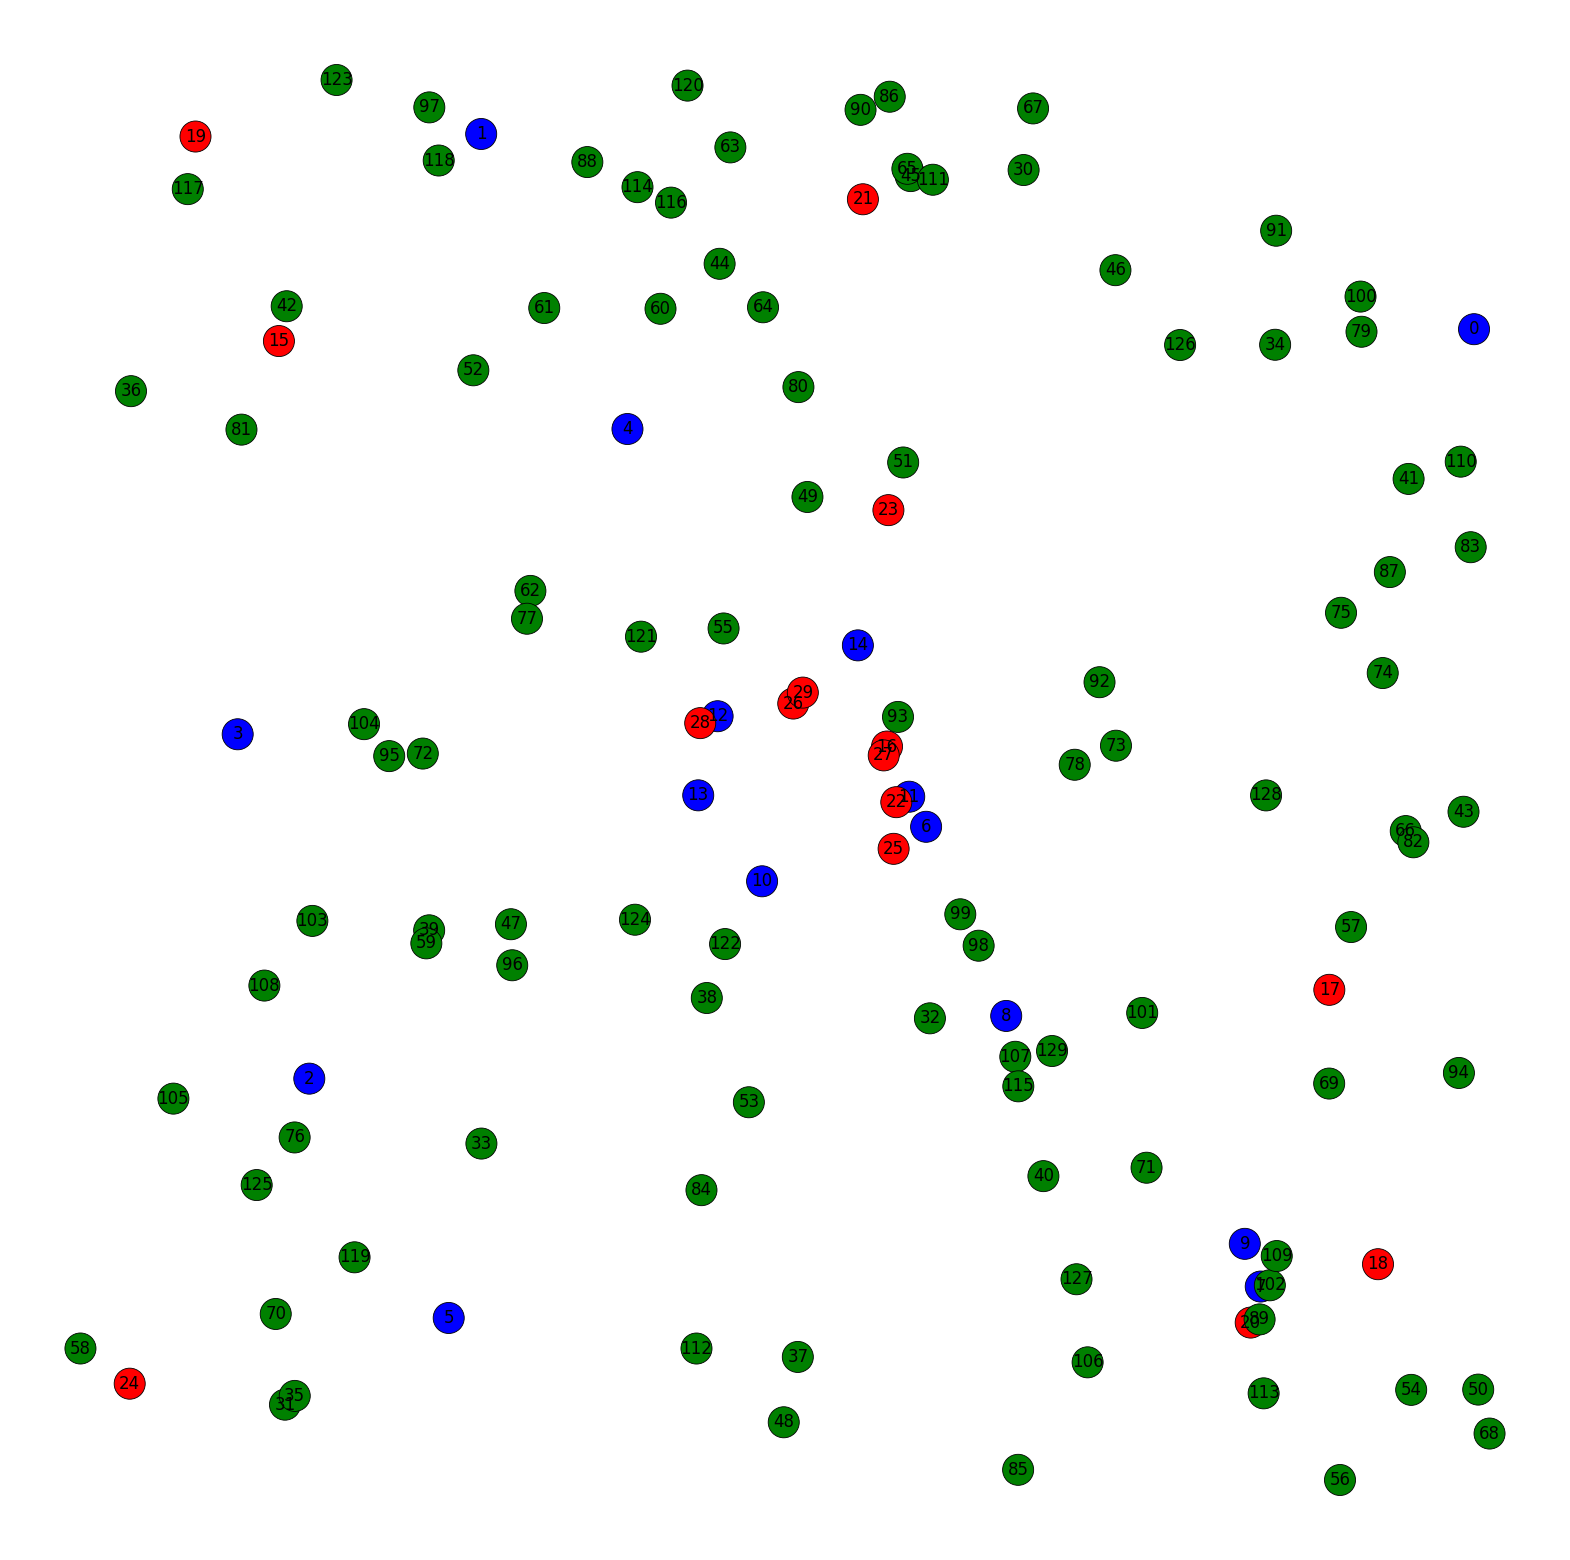

In [384]:
DrawInitG(G,(graph_size,graph_size), withedges=False)

## Optimizing the model

In [385]:
#Creating the model
pcf = gb.Model('Primary care facility')

### Decision variables

In [386]:
# Variable decision x1, x1[k] = 1 if clinic k is established
x1 = pcf.addVars(index_of_clinic,vtype=gb.GRB.BINARY, name='x1')
# Variable decision x2, x2[j] = 1 if hospital j is established
x2 = pcf.addVars(index_of_hospitals,vtype=gb.GRB.BINARY, name='x2')
# Variable decision u, u[i][k] = number of patient who go to node i to clinic k
u = pcf.addVars([(i,k) for i in index_of_demand_points for k in index_of_clinic],
                # we have to precise the index range of u, if not it will not compute because gurobi is lost with the index
                lb = 0, # lower bound (u_ik >= 0)
                obj=[G.edges[(i,k)]['dist'] for i in index_of_demand_points for k in index_of_clinic], 
                vtype=gb.GRB.INTEGER, name='u')
# Variable decision v, v[k][j] = number of patient who go to clinic k to hospital j
v = pcf.addVars([(k,j) for k in index_of_clinic for j in index_of_hospitals],
                lb = 0, 
                obj=[G[k][j]['dist'] for k in index_of_clinic for j in index_of_hospitals], 
                vtype=gb.GRB.INTEGER, name='v')
pcf.update()
pcf.write('pcf.lp')


### Constraints

In [387]:
pcf.addConstrs((u.sum(i, '*') == C[i] for i in index_of_demand_points), name='29')
pcf.addConstrs((v.sum(k, '*') >= theta[k]*u.sum('*',k) for k in index_of_clinic), name='30')
# the constraint 30 was a main problem to unfeasible. To solve it I put an inequality instead of an equality 
# because it is almost impossible that theta[k]*u.sum('*',k) is an integer

pcf.addConstrs((u.sum('*', k) <= C[k]*x1[k] for k in index_of_clinic), name='31')
pcf.addConstrs((v.sum('*', j) <= C[j]*x2[j] for j in index_of_hospitals), name='32')

pcf.addConstr(x1.sum('*') == p , name='33')
pcf.addConstr(x2.sum('*') == q , name='34')

pcf.update()
pcf.write('pcf.lp')

# Domain constraints useless before be can define it 

In [388]:
totalcapacityclinic = 0
for k in index_of_clinic:
    totalcapacityclinic = totalcapacityclinic + C[k]
totalcapacityhospital = 0
for j in index_of_hospitals:
    totalcapacityhospital = totalcapacityhospital + C[j]
totaldemand = 0
for i in index_of_demand_points:
    # print(C[i])
    totaldemand = totaldemand + C[i]
print(totalcapacityclinic)
print(totalcapacityhospital)
print(totaldemand)

3100
15500
1486


In [390]:
pcf.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 147 rows, 1755 columns and 5010 nonzeros
Model fingerprint: 0xfe768f96
Variable types: 0 continuous, 1755 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e-01, 2e+03]
  Objective range  [1e-01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 2e+01]
Presolved: 147 rows, 1755 columns, 5010 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 6
  Implied bound: 2
  MIR: 3
  Flow cover: 2

Explored 1 nodes (262 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 4: 9147.32 9164.21 9351.27 9714.86 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.147323128779e+03, best bound 9.146627980556e+03, gap 0.0076%


That means that the minimal distance to bring all patients to a clinic or an hospital is 7461 km or m i am not really sure.

In [391]:
# this part allows us to see with node is activated e.g where clinics and hospitals are established
# we see also the flow (e.g the number of people) between demand point and clinic and clinic and hospital
print('Obj: %g' % pcf.objVal)
print(pcf.getVars())
print ()

for y in pcf.getVars():
    if y.x >= 1:
        print ('%s=%g' % (y.varName, y.x), end = ' ')

Obj: 9147.32
[<gurobi.Var x1[0] (value 1.0)>, <gurobi.Var x1[1] (value 1.0)>, <gurobi.Var x1[2] (value -0.0)>, <gurobi.Var x1[3] (value -0.0)>, <gurobi.Var x1[4] (value -0.0)>, <gurobi.Var x1[5] (value -0.0)>, <gurobi.Var x1[6] (value 1.0)>, <gurobi.Var x1[7] (value -0.0)>, <gurobi.Var x1[8] (value -0.0)>, <gurobi.Var x1[9] (value -0.0)>, <gurobi.Var x1[10] (value -0.0)>, <gurobi.Var x1[11] (value -0.0)>, <gurobi.Var x1[12] (value 1.0)>, <gurobi.Var x1[13] (value -0.0)>, <gurobi.Var x1[14] (value 1.0)>, <gurobi.Var x2[15] (value -0.0)>, <gurobi.Var x2[16] (value -0.0)>, <gurobi.Var x2[17] (value 0.0)>, <gurobi.Var x2[18] (value 0.0)>, <gurobi.Var x2[19] (value 1.0)>, <gurobi.Var x2[20] (value 0.0)>, <gurobi.Var x2[21] (value -0.0)>, <gurobi.Var x2[22] (value 1.0)>, <gurobi.Var x2[23] (value 1.0)>, <gurobi.Var x2[24] (value 0.0)>, <gurobi.Var x2[25] (value -0.0)>, <gurobi.Var x2[26] (value -0.0)>, <gurobi.Var x2[27] (value -0.0)>, <gurobi.Var x2[28] (value 1.0)>, <gurobi.Var x2[29] (val

In [392]:
u

{(30, 0): <gurobi.Var u[30,0] (value 4.0)>,
 (30, 1): <gurobi.Var u[30,1] (value -0.0)>,
 (30, 2): <gurobi.Var u[30,2] (value -0.0)>,
 (30, 3): <gurobi.Var u[30,3] (value -0.0)>,
 (30, 4): <gurobi.Var u[30,4] (value -0.0)>,
 (30, 5): <gurobi.Var u[30,5] (value -0.0)>,
 (30, 6): <gurobi.Var u[30,6] (value -0.0)>,
 (30, 7): <gurobi.Var u[30,7] (value -0.0)>,
 (30, 8): <gurobi.Var u[30,8] (value -0.0)>,
 (30, 9): <gurobi.Var u[30,9] (value -0.0)>,
 (30, 10): <gurobi.Var u[30,10] (value -0.0)>,
 (30, 11): <gurobi.Var u[30,11] (value -0.0)>,
 (30, 12): <gurobi.Var u[30,12] (value -0.0)>,
 (30, 13): <gurobi.Var u[30,13] (value -0.0)>,
 (30, 14): <gurobi.Var u[30,14] (value 2.0)>,
 (31, 0): <gurobi.Var u[31,0] (value -0.0)>,
 (31, 1): <gurobi.Var u[31,1] (value -0.0)>,
 (31, 2): <gurobi.Var u[31,2] (value -0.0)>,
 (31, 3): <gurobi.Var u[31,3] (value -0.0)>,
 (31, 4): <gurobi.Var u[31,4] (value -0.0)>,
 (31, 5): <gurobi.Var u[31,5] (value -0.0)>,
 (31, 6): <gurobi.Var u[31,6] (value -0.0)>,
 (

In [393]:
v

{(0, 15): <gurobi.Var v[0,15] (value -0.0)>,
 (0, 16): <gurobi.Var v[0,16] (value -0.0)>,
 (0, 17): <gurobi.Var v[0,17] (value -0.0)>,
 (0, 18): <gurobi.Var v[0,18] (value -0.0)>,
 (0, 19): <gurobi.Var v[0,19] (value -0.0)>,
 (0, 20): <gurobi.Var v[0,20] (value -0.0)>,
 (0, 21): <gurobi.Var v[0,21] (value -0.0)>,
 (0, 22): <gurobi.Var v[0,22] (value -0.0)>,
 (0, 23): <gurobi.Var v[0,23] (value 72.0)>,
 (0, 24): <gurobi.Var v[0,24] (value -0.0)>,
 (0, 25): <gurobi.Var v[0,25] (value -0.0)>,
 (0, 26): <gurobi.Var v[0,26] (value -0.0)>,
 (0, 27): <gurobi.Var v[0,27] (value -0.0)>,
 (0, 28): <gurobi.Var v[0,28] (value -0.0)>,
 (0, 29): <gurobi.Var v[0,29] (value -0.0)>,
 (1, 15): <gurobi.Var v[1,15] (value -0.0)>,
 (1, 16): <gurobi.Var v[1,16] (value -0.0)>,
 (1, 17): <gurobi.Var v[1,17] (value -0.0)>,
 (1, 18): <gurobi.Var v[1,18] (value -0.0)>,
 (1, 19): <gurobi.Var v[1,19] (value 170.0)>,
 (1, 20): <gurobi.Var v[1,20] (value -0.0)>,
 (1, 21): <gurobi.Var v[1,21] (value -0.0)>,
 (1, 22):

In [394]:
# Creating xfinal, the dict of all active edges

xfinal = dict(u)

# just checking if all the population go to a clinic
totalpop = 0
for xtuple in list(xfinal) :
    # print(xfinal[xtuple])
    # print(xfinal[xtuple].x)
    totalpop = totalpop + xfinal[xtuple].x
print(totalpop) 
print(totalpop == totaldemand) 

xfinal.update(v)

# Removing the key from the dict if the value is 0, e.G the edge isn't active
for xtuple in list(xfinal) :
    # print(xfinal[xtuple])
    # print(xfinal[xtuple].x)
    # print(xtuple)
    if xfinal[xtuple].x == 0 :
        xfinal.pop(xtuple, None)



1486.0
True


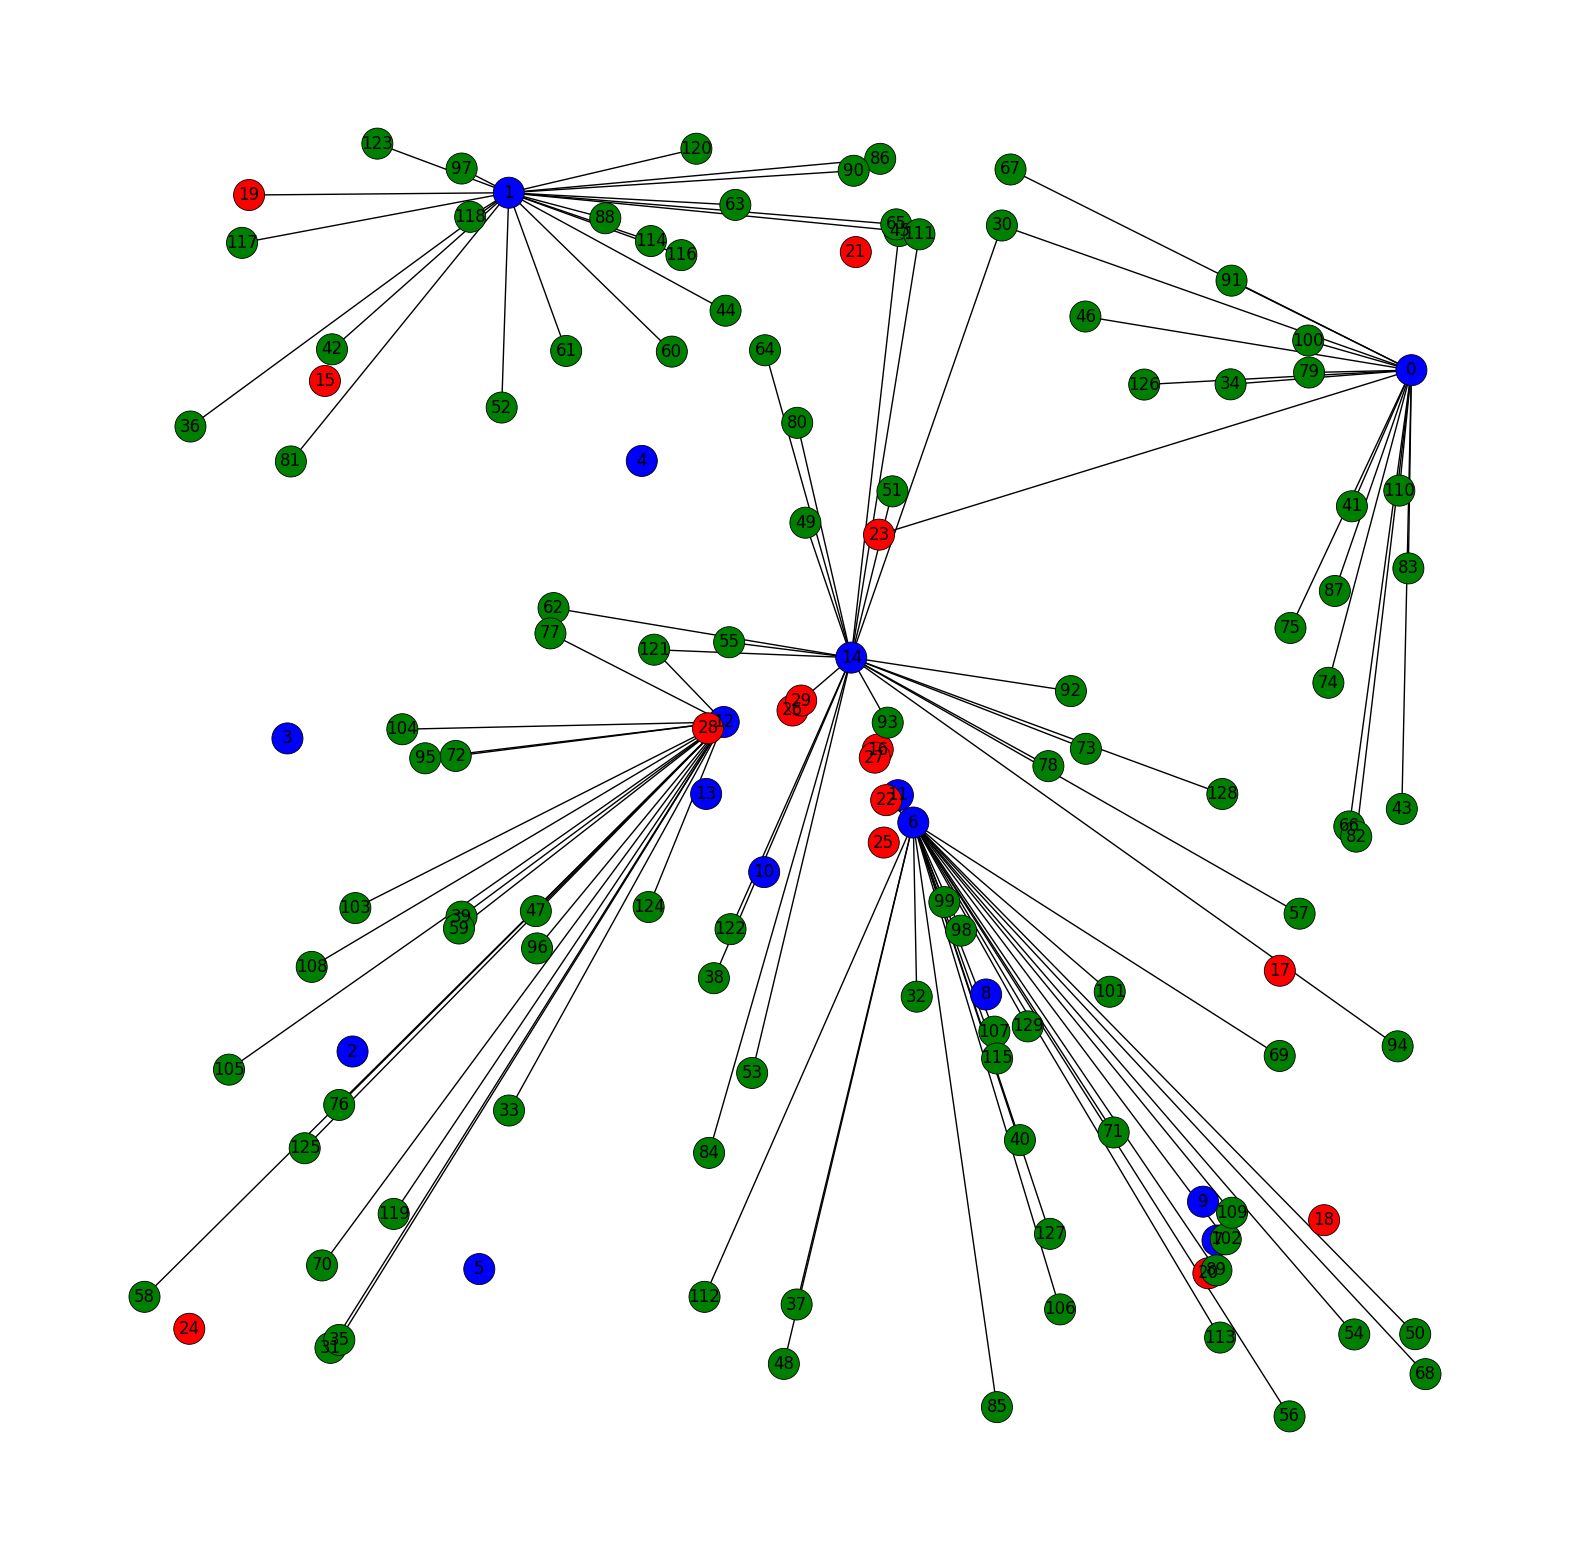

In [395]:
DrawSol(G, (graph_size,graph_size), xfinal)

### Compared with real data


Position of clinics in the city of Nantes, France


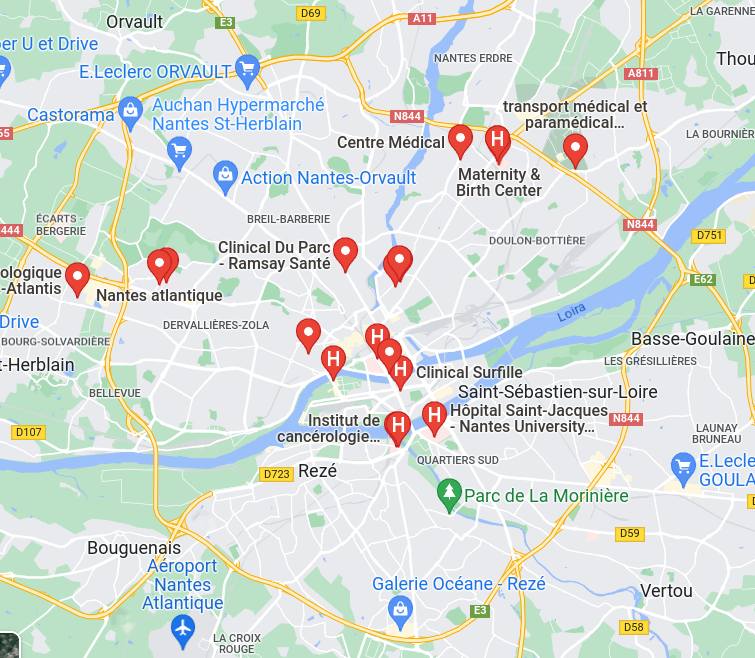

Position of hospital in the city of Nantes, France

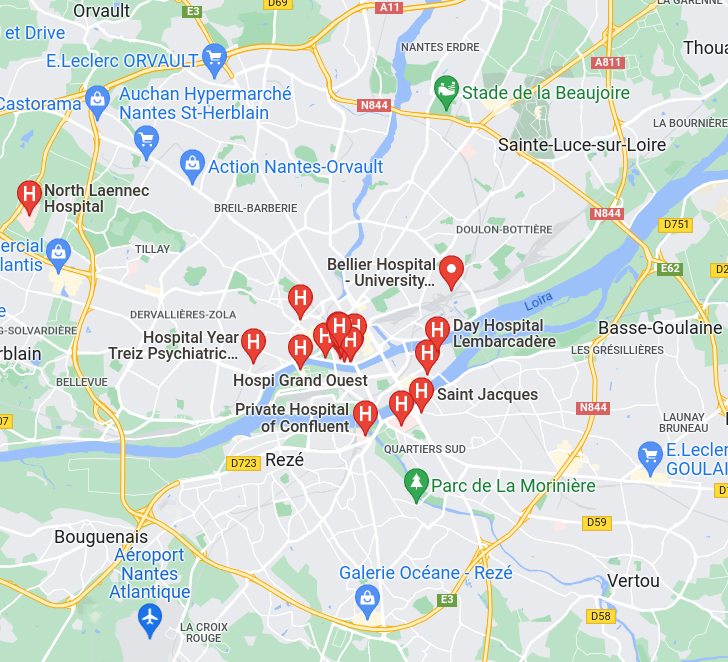

In real word, we see that hospitals and clinics a more centered. And this is logic because if we see a town like a circle, the center is the position optimal to go anywhere
(if our demand is randomize like here e.g everywhere in the city we can want to go to the hospital)
If we consider that hospitals and clinics in the center have more capacity (which true in general), we obtain a result quite similar to  the reality.